In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from ipywidgets import IntProgress
from IPython.display import display

In [4]:
from model_builder import ModelBuilder

In [5]:
import json

In [6]:
from var_table import VarTable

In [7]:
var_table = VarTable()

In [8]:
experiments_count = 200

In [9]:
M = 10 ** 10

In [10]:
df = pd.read_csv('variables.csv')

In [11]:
config = {}

In [12]:
solvers = ['glpk', 'cbc', 'mpec_minlp', 'single_point genetic', 'two_points genetic', 'uniform genetic', 'random']

In [13]:
fitnesses_dataset = {}
durations_dataset = {}

In [14]:
# fitness
for solver in solvers:
    fitnesses_dataset[solver] = []

In [15]:
# duration
for solver in solvers[:-1]:
    durations_dataset[solver] = []

In [16]:
fitnesses_dataset['variables'] = []
fitnesses_dataset['constraints'] = []

In [17]:
def find_data_by_name(dataset, name):
    for data in dataset:
        data_name = data['name']
        if data_name == name:
            return data

In [18]:
def find_solution_by_config(solutions, config):
    for solution in solutions:
        solution_config = solution['config']
        if solution_config == config:
            return solution

In [19]:
def draw_durations_polt(df):
    plt.title('durations')
    plt.xlabel('experiment')
    plt.ylabel('duration, sec')
    sns.lineplot(data=df)

In [20]:
def draw_relative_fitnesses_polt(df):
    df_melted = pd.melt(df)
    title = 'fitnesses'
    sns.violinplot(x='variable', y='value', data=df_melted, width=0.7, dodge=False, hue='variable').set(title=title)
    plt.xlabel('solver')
    plt.xticks(rotation=75)
    plt.ylabel('fitness / random fitness')

In [21]:
def read_input_data(experiment_number):
        k = df['k'][experiment_number]
        nested_directory = var_table.get_nested_directory(experiment_number)
        T_file_path = '{}/T.csv'.format(nested_directory)
        D_file_path = '{}/D.csv'.format(nested_directory)
        sum_D_file_path = '{}/sum_D.csv'.format(nested_directory)
        C_file_path = '{}/C.csv'.format(nested_directory)
        E_file_path = '{}/E.csv'.format(nested_directory)
        T_df = pd.read_csv(T_file_path, index_col=False, header=None)
        D_df = pd.read_csv(D_file_path, index_col=False, header=None)
        sum_D_df = pd.read_csv(sum_D_file_path, index_col=False, header=None)
        C_df = pd.read_csv(C_file_path, index_col=False, header=None)
        E_df = pd.read_csv(E_file_path, index_col=False, header=None)
        T = T_df.to_numpy()
        D = D_df.to_numpy()
        sum_D = sum_D_df.to_numpy()
        C = C_df.to_numpy()
        E = E_df.to_numpy()
        return k, T, sum_D, C, E

In [22]:
# fitness
for experiment_number in range(experiments_count):
    nested_directory = var_table.get_nested_directory(experiment_number)
    file_path = '{}/solutions.json'.format(nested_directory)
    file = open(file_path, 'r')
    content = file.read()
    dataset = json.loads(content)
    file.close()
    for solver in solvers:
        data = find_data_by_name(dataset, solver)
        solutions = data['solutions']
        solution = find_solution_by_config(solutions, config)
        result = solution['result']
        fitness = result['fitness']
        fitnesses_dataset[solver].append(fitness)

In [23]:
# duration
for experiment_number in range(experiments_count):
    nested_directory = var_table.get_nested_directory(experiment_number)
    file_path = '{}/solutions.json'.format(nested_directory)
    file = open(file_path, 'r')
    content = file.read()
    dataset = json.loads(content)
    file.close()
    for solver in solvers[:-1]:
        data = find_data_by_name(dataset, solver)
        solutions = data['solutions']
        solution = find_solution_by_config(solutions, config)
        result = solution['result']
        duration = result['duration']
        durations_dataset[solver].append(duration)

In [24]:
progress = IntProgress(min=0, max=experiments_count, value=0, description='progress', bar_style='success')
display(progress)
for experiment_number in range(experiments_count):
    k, T, sum_D, C, E = read_input_data(experiment_number)
    model_builder = ModelBuilder(M, k, T, sum_D, C, E)
    model = model_builder.build()
    A_count = len(model.A)
    f_count = len(model.f)
    variables_count = A_count + f_count
    constraints_count = len(model.constraints)
    fitnesses_dataset['variables'].append(variables_count)
    fitnesses_dataset['constraints'].append(constraints_count)
    progress.value += 1

IntProgress(value=0, bar_style='success', description='progress', max=200)

In [25]:
fitnesses_df = pd.DataFrame(fitnesses_dataset)
relative_fitnesses = pd.DataFrame()
relative_fitnesses['glpk'] = fitnesses_df['glpk']
relative_fitnesses['cbc'] = fitnesses_df['cbc']
relative_fitnesses['mpec_minlp'] = fitnesses_df['mpec_minlp']
relative_fitnesses['single_point genetic'] = fitnesses_df['single_point genetic']
relative_fitnesses['two_points genetic'] = fitnesses_df['two_points genetic']
relative_fitnesses['uniform genetic'] = fitnesses_df['uniform genetic']
for i in range(len(fitnesses_df)):
    random = fitnesses_df['random'][i]
    relative_fitnesses['glpk'][i] = random / relative_fitnesses['glpk'][i]
    relative_fitnesses['cbc'][i] = random / relative_fitnesses['cbc'][i]
    relative_fitnesses['mpec_minlp'][i] = random / relative_fitnesses['mpec_minlp'][i]
    relative_fitnesses['single_point genetic'][i] = random / relative_fitnesses['single_point genetic'][i]
    relative_fitnesses['two_points genetic'][i] = random / relative_fitnesses['two_points genetic'][i]
    relative_fitnesses['uniform genetic'][i] = random / relative_fitnesses['uniform genetic'][i]

In [26]:
fitnesses_df

,glpk,cbc,mpec_minlp,single_point genetic,two_points genetic,uniform genetic,random,variables,constraints
0,-92.0,-92.0,-92.0,-92.0,-92.0,-92.0,-92.0,100,228
1,-56.0,-51.0,-56.0,-56.0,-56.0,-50.0,-66.0,200,514
2,-322.0,-282.0,-322.0,-303.0,-322.0,-322.0,-322.0,300,773
3,-330.0,-330.0,-330.0,-330.0,-306.0,-306.0,-330.0,400,1050
4,-504.0,-496.0,-504.0,-484.0,-482.0,-484.0,-528.0,500,1318
...,...,...,...,...,...,...,...,...,...
195,-7188.0,-4409.0,-7188.0,-4693.0,-4492.0,-4690.0,-5101.0,19600,55800
196,-16546.0,-18075.0,-16546.0,-17034.0,-16811.0,-16572.0,-19099.0,19700,55951
197,-14673.0,-13008.0,-14673.0,-12868.0,-13240.0,-12684.0,-13338.0,19800,56278
198,-14547.0,-15598.0,-14547.0,-14121.0,-13416.0,-13892.0,-15377.0,19900,56566


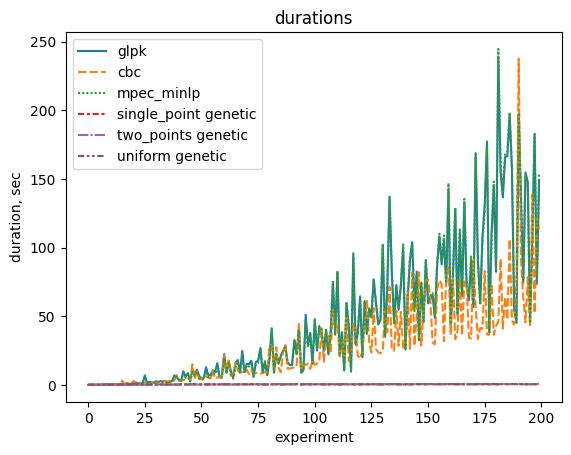

In [27]:
durations_df = pd.DataFrame(durations_dataset)
draw_durations_polt(durations_df)

### Констатация:
1. Скачкообразность графика может быть объяснена тем, 
что на величину потребного времени влияет не только количество переменных, но и количество ограничений.

### Выводы:
1. С увеличением числа переменных и ограничений в модели 
потребное решателям время для работы увеличивается по экспоненте
2. Существует такое правило формирования модели, 
при котором не происходит экспоненциальный рост потребного времени для работы 
составленного генетического алгоритма

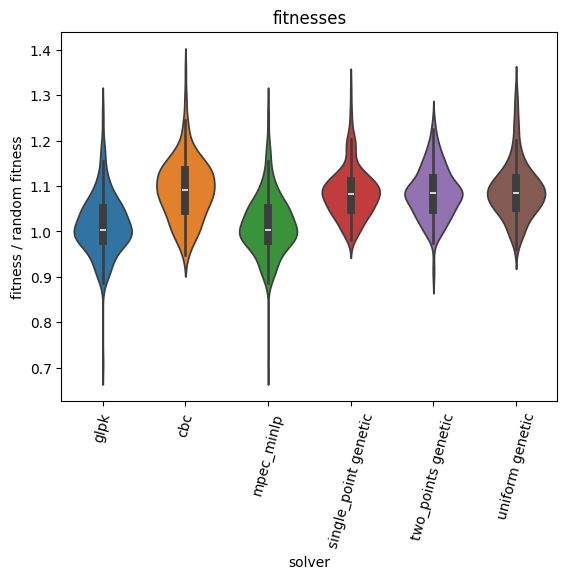

In [28]:
draw_relative_fitnesses_polt(relative_fitnesses)

### Выводы:
1. Существует такое правило формирования модели, 
при котором в условии отсутствия экспоненциального роста потребного времени работы различных реализаций 
генетического алгоритма качество поиска оптимального решения не только не ухудшается, 
но и превосходит результаты стандартных решателей
2. Стандартные решатели в ряде экспериментов демонстрируют решения хуже, 
чем решение полученное при случайной его генерации